In [1]:
import numpy as np 
import pandas as pd 
import os

import csv as csv
import sklearn as scl

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

# Exploratory Data Analysis

In [2]:
train = pd.read_csv('data/train.csv') 
train.shape

(891, 12)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
test = pd.read_csv('data/test.csv') 
test.shape

(418, 11)

In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
features = list(set(test.columns) - {'Name'})
features

['Cabin',
 'Parch',
 'Sex',
 'Fare',
 'SibSp',
 'Age',
 'Embarked',
 'Ticket',
 'PassengerId',
 'Pclass']

In [8]:
# Impute missing values using the median for numeric columns and the most common value for string columns.
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [9]:
# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
common = train[features].append(test[features])
common = DataFrameImputer().fit_transform(common)
common.describe()

,Parch,Fare,SibSp,Age,PassengerId,Pclass
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.385027,33.281086,0.498854,29.503186,655.000000,2.294882
std,0.865560,51.741500,1.041658,12.905241,378.020061,0.837836
min,0.000000,0.000000,0.000000,0.170000,1.000000,1.000000
25%,0.000000,7.895800,0.000000,22.000000,328.000000,2.000000
50%,0.000000,14.454200,0.000000,28.000000,655.000000,3.000000
75%,0.000000,31.275000,1.000000,35.000000,982.000000,3.000000
max,9.000000,512.329200,8.000000,80.000000,1309.000000,3.000000


In [10]:
# Change categorical features  to columns of integer values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in features:
    common[feature] = le.fit_transform(common[feature])

In [11]:
train2 = common[0:train.shape[0]]
test2 = common[train.shape[0]::]

In [12]:
correlation_matrix = train2.corr()
correlation_matrix

,Cabin,Parch,Sex,Fare,SibSp,Age,Embarked,Ticket,PassengerId,Pclass
Cabin,1.000000,0.014164,-0.074228,0.057022,0.008424,0.006034,0.071185,-0.004401,-0.025823,-0.062211
Parch,0.014164,1.000000,-0.245489,0.361297,0.423338,-0.165856,0.039798,0.019936,-0.001652,0.018443
Sex,-0.074228,-0.245489,1.000000,-0.266027,-0.123164,0.078462,0.108262,0.060416,0.042939,0.131900
Fare,0.057022,0.361297,-0.266027,1.000000,0.369257,0.123296,-0.155600,-0.169863,-0.007500,-0.721772
SibSp,0.008424,0.423338,-0.123164,0.369257,1.000000,-0.250597,0.065635,0.068976,-0.065229,0.078141
Age,0.006034,-0.165856,0.078462,0.123296,-0.250597,1.000000,-0.016476,-0.072190,0.034809,-0.341013
Embarked,0.071185,0.039798,0.108262,-0.155600,0.065635,-0.016476,1.000000,0.000032,0.013128,0.162098
Ticket,-0.004401,0.019936,0.060416,-0.169863,0.068976,-0.072190,0.000032,1.000000,-0.056470,0.322475
PassengerId,-0.025823,-0.001652,0.042939,-0.007500,-0.065229,0.034809,0.013128,-0.056470,1.000000,-0.035144
Pclass,-0.062211,0.018443,0.131900,-0.721772,0.078141,-0.341013,0.162098,0.322475,-0.035144,1.000000


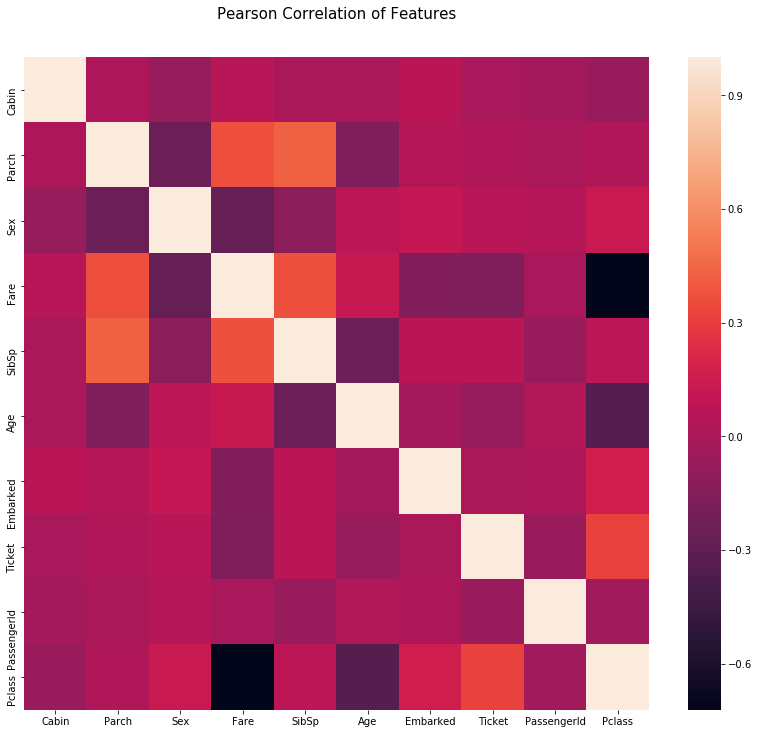

In [13]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix)

In [14]:
features2 = ['Sex','Age','Pclass','Parch','Embarked', 'Cabin']
train3 = train2[features2]
test3 = test2[features2]
correlation_matrix2 = train3.corr()
correlation_matrix2

,Sex,Age,Pclass,Parch,Embarked,Cabin
Sex,1.000000,0.078462,0.131900,-0.245489,0.108262,-0.074228
Age,0.078462,1.000000,-0.341013,-0.165856,-0.016476,0.006034
Pclass,0.131900,-0.341013,1.000000,0.018443,0.162098,-0.062211
Parch,-0.245489,-0.165856,0.018443,1.000000,0.039798,0.014164
Embarked,0.108262,-0.016476,0.162098,0.039798,1.000000,0.071185
Cabin,-0.074228,0.006034,-0.062211,0.014164,0.071185,1.000000


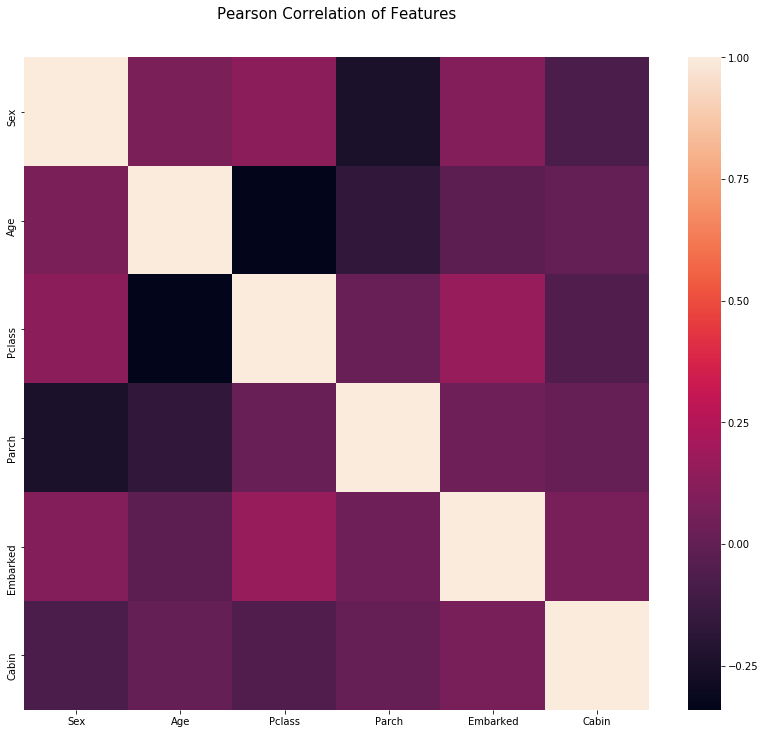

In [15]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix2)

In [16]:
train_X = train3.values
test_X = test3.values
train_y = train['Survived']

# Split dataset

In [17]:
from sklearn.utils import shuffle

df_train = train3.join(pd.DataFrame({'Survived': train_y}))
size = int(df_train.shape[0] * 0.8)
print(size)
train4 = shuffle(df_train)
train_80 = train4[:size]
train_20 = train4[size:]

712


In [18]:
cv_train_X = train_80[features2].values
cv_test_X = train_20[features2].values
cv_train_y = train_80['Survived']
cv_test_y = train_20['Survived']

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_X, train_y)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [20]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(train_X)
accuracy_score(train_y, y_pred)

0.8013468013468014

In [21]:
# Cross-validation
model2 = LogisticRegression()
model2.fit(cv_train_X, cv_train_y)
y_pred = model2.predict(cv_test_X)
accuracy_score(cv_test_y, y_pred)

0.8435754189944135

In [22]:
# Make predictions
preds = model.predict(test_X)

In [23]:
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': preds })
submission.to_csv('submission.csv', index=False)

# XGBoost

In [24]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)

In [25]:
y_pred = gbm.predict(train_X)
accuracy_score(train_y, y_pred)

/Users/leyla/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8720538720538721

In [26]:
# Cross-validation
gbm2 = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(cv_train_X, cv_train_y)
y_pred = gbm2.predict(cv_test_X)
accuracy_score(cv_test_y, y_pred)

/Users/leyla/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8547486033519553

In [27]:
preds2 = gbm.predict(test_X)

/Users/leyla/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [28]:
submission2 = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                             'Survived': preds2 })
submission2.to_csv('submission2.csv', index=False)

## Tip

If you want to drive up your score try to play with XGBoost parameters

## Grid Search

In [29]:
# is used all features

train_X = train2.values
test_X = test2.values
train_y = train['Survived']

In [31]:
import warnings

warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [32]:
from sklearn import model_selection
import xgboost as xgb

# XGBoost - sklearn method
gbm = xgb.XGBClassifier()

xgb_params = {
'learning_rate': [0.01, 0.05, 0.1],
'n_estimators': [300],
'max_depth': [3, 4, 5, 7, 9],
'gamma': [0, 1],
'subsample': [0.7, 1],
'colsample_bytree': [0.7, 1]
}

grid = model_selection.GridSearchCV(gbm, xgb_params, cv=5)
grid.fit(train_X,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [300], 'max_depth': [3, 4, 5, 7, 9], 'gamma': [0, 1], 'subsample': [0.7, 1], 'colsample_bytree': [0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
print('Best Params:')
print(grid.best_params_)
print('Best CV Score:')
print(grid.best_score_)

Best Params:
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.7}
Best CV Score:
0.8383838383838383
